### Notebook to visualize Dec. 1th 2015 with RI autoencoder

In [2]:
%reload_ext autoreload
%autoreload 2
import os
import gc
import re
import sys
import glob
import numpy as np
import scipy as sc
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC 
from scipy.stats import mode
from tensorflow.python.keras.models import Model
from tensorflow.data.experimental import parallel_interleave
 
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import patches as mpl_patches
from sklearn.cluster import AgglomerativeClustering as HAC
from sklearn.manifold import TSNE

# for centroid
from scipy.cluster.hierarchy import centroid, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import euclidean_distances

In [1]:
!pip3 install -U scikit-learn==0.24.0

     |################################| 22.2 MB 14.6 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

spark-sklearn 0.3.0 requires scikit-learn<0.20,>=0.18.1, but you'll have scikit-learn 0.24.0 which is incompatible.


In [3]:
from matplotlib.backends.backend_pdf import PdfPages

In [4]:
from matplotlib.patches import Ellipse, Circle

In [5]:
from scipy.cluster.hierarchy import dendrogram
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
from sklearn.neighbors import NearestCentroid
# https://stackoverflow.com/questions/56456572/how-to-get-agglomerative-clustering-centroid-in-python-scikit-learn

In [6]:
libdir = '/home/tkurihana/scratch-midway2/clouds/src_analysis/lib_hdfs'
sys.path.insert(1,os.path.join(sys.path[0],libdir))
from alignment_lib import  decode_cloud_flag, const_clouds_array
from analysis_lib import _get_colors, _gen_patches
from lib_modis02 import proc_sds

In [7]:
def load_latest_model(model_dir, mtype):
    #TODO add restart model dir and restart argument?
    latest = 0, None
    # get trained wegiht 
    for m in os.listdir(model_dir):
        if ".h5" in m and mtype in m:
            epoch = int(m.split("-")[1].replace(".h5", ""))
            latest = max(latest, (epoch, m))

    epoch, model_file = latest

    if not os.listdir(model_dir):
        raise NameError("no directory. check model path again")

    print(" Load {} at {} epoch".format(mtype, epoch))
    model_def = model_dir+'/'+mtype+'.json'
    model_weight = model_dir+'/'+mtype+'-'+str(epoch)+'.h5'
    with open(model_def, "r") as f:
        model = tf.keras.models.model_from_json(f.read())
    model.load_weights(model_weight)
    return model

In [8]:
def data_extractor_fn(filelist,prefetch=1,height=None, width=None, read_threads=1, distribute=(1, 0), shape_size=2):
    def parser(ser):
        """
        Decode & Pass datast in tf.record
        *Cuation*
        floating point: tfrecord data ==> tf.float64
        """

        features = {
            "shape": tf.FixedLenFeature([shape_size], tf.int64),
            "patch": tf.FixedLenFeature([], tf.string),
            "filename": tf.FixedLenFeature([], tf.string),
            "coordinate": tf.FixedLenFeature([2], tf.int64),
        }        
        decoded = tf.parse_single_example(ser, features)
        patch = tf.reshape(
            tf.decode_raw(decoded["patch"], tf.float64), decoded["shape"]
        )
        patch = tf.image.resize(tf.expand_dims(patch, axis=0), (height, width))
        coord = decoded['coordinate']
        return patch, coord
    
    dataset = (
        tf.data.Dataset.list_files(filelist, shuffle=True)
            .shard(*distribute)
            .apply(
            parallel_interleave(
                lambda f: tf.data.TFRecordDataset(f).map(parser),
                cycle_length=read_threads,
                sloppy=True,
            )
        )
    )
    iterator = dataset.make_one_shot_iterator()

    next_element = iterator.get_next()
    patch_list = []
    coord_list = []
    with tf.Session() as sess:
        try:
            while True:
                patch, coord = sess.run(next_element)
                patch_list.append(patch)
                coord_list.append(coord)
        except tf.errors.OutOfRangeError:
            print("OutOfRage --> finish process")
            pass
    return patch_list, coord_list

#### Load tfdata and check if it's correct for our RI model

In [9]:
tf_datadir = "/project2/foster/clouds/data/clouds_laads_multiprocessed_20151201"

In [10]:
patches_list = []
h=w=32
shape_size=3
patches_list, coord_list = data_extractor_fn(os.path.join(tf_datadir, '*tfrecord'), height=h, width=w,shape_size=shape_size)
print("NORMAL END")

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
OutOfRage --> finish process
NORMAL END


In [11]:
patches = np.concatenate(patches_list, axis=0)
patches.shape

(491, 32, 32, 6)

In [12]:
gc.collect()

2092

-----------------
### Colorbar

In [4]:
colors = ['blueviolet','cornflowerblue','blue','teal',
         'aqua','palegreen', 'yellowgreen', 'pink',
         'yellow','orange','red','maroon', ]

In [5]:
test_array = np.ones((30,30))
for i in range(30):
    for j in range(30):
        test_array[i,j] = np.random.randint(0,13,1)

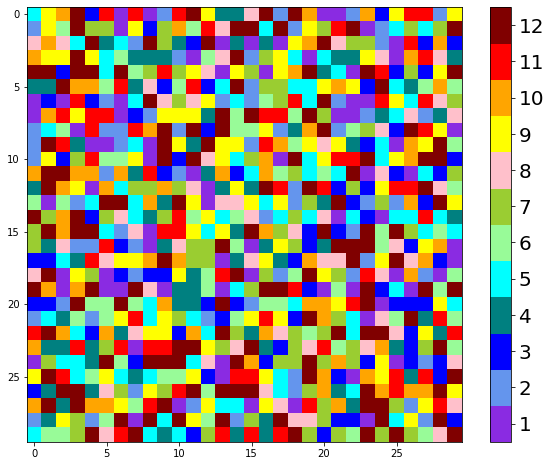

In [18]:
"""https://stackoverflow.com/questions/18704353/correcting-matplotlib-colorbar-ticks
"""
cmap_name = 'my_list'
font_size=20
plt.figure(figsize=(10,8))
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=12)
plt.imshow(test_array, cmap=cmap)
#plt.title("# cloud with model " )
#plt.colorbar(orientation='horizontal')
cb = plt.colorbar(orientation='vertical',) # fraction=0.047, pad=0.08
loc = np.arange(12) + .5
cb.set_ticks(loc)
#cb.set_ticklabels(labels)
labels = [ str(i) for i in range(1,13,1)]
cb.ax.tick_params(labelsize=font_size)
cb.set_ticklabels(labels)

MEMO: OK!

----------------
### Create colorbar with 1-12 scale

In [19]:
colors = ['blueviolet','cornflowerblue','blue','teal',
         'aqua','palegreen', 'yellowgreen', 'pink',
         'yellow','orange','red','maroon', ]

In [21]:
len(colors)

12

In [14]:
test_array = np.ones((30,30))
for i in range(30):
    for j in range(30):
        test_array[i,j] = np.random.randint(0,13,1)

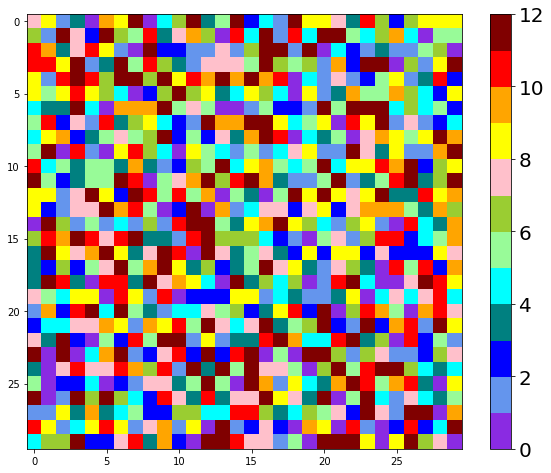

In [20]:
cmap_name = 'my_list'
font_size=20
plt.figure(figsize=(10,8))
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=12)
plt.imshow(test_array, cmap=cmap)
#plt.title("# cloud with model " )
#plt.colorbar(orientation='horizontal')
cb = plt.colorbar(orientation='vertical',) # fraction=0.047, pad=0.08
cb.ax.tick_params(labelsize=font_size)

----------------------------
### Clustering

In [13]:
def compute_hac3(encoder, decoder=None, clf=None,patches=None,layer_name="leaky_re_lu_23"):
    # RI model
    encs = encoder.predict(patches)
    gc.collect()

    # get another layers from Decoder
    model = decoder
    rep  = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    pred = rep.predict(encs)

    n,h,w,c = pred.shape
    clustering = clf.fit(pred.reshape(n, h*w*c))
    clabels = clustering.labels_
    return clabels, clustering, pred

Load model and set classifier

In [14]:
model_datadir = '/home/tkurihana/rotate_invariant/stepbystep/transform/output_model'

In [15]:
expname="67011582"

In [16]:
model_dir = os.path.join(model_datadir,str(expname) )
encoder = load_latest_model(model_dir, mtype='encoder')
decoder = load_latest_model(model_dir, mtype='decoder')

 Load encoder at 100 epoch
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
 Load decoder at 100 epoch
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Set up ncluster for HAC

In [17]:
nclusters = 12

In [18]:
clf_dict = {
    'HAC': HAC(n_clusters=nclusters,memory=None,compute_full_tree=True,compute_distances=True) ,
}
# define a model selected from metrics
clf = clf_dict['HAC']

In [19]:
clabels, clustering, pred = compute_hac3(encoder,decoder,clf,patches,layer_name="leaky_re_lu_23")

-----------------------
### 2020/12/29: Visualize dendrogram and Image

In [27]:
import sklearn
sklearn.__version__

'0.24.0'

In [33]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # need to be >0.24.0
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

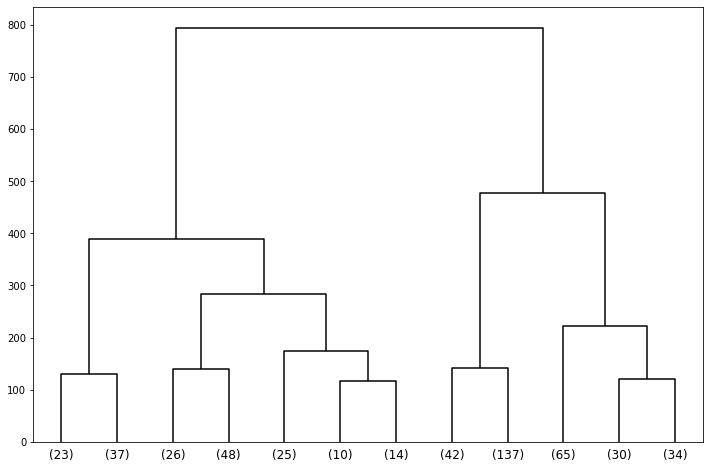

In [40]:
fig = plt.figure(figsize=(12,8))
plot_dendrogram(clustering, truncate_mode='lastp', p=12, above_threshold_color='black',color_threshold=12)
plt.show()

#### Get centroids
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.centroid.html

In [72]:
def comp_linkage(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # need to be >0.24.0
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    return linkage_matrix

In [74]:
link = comp_linkage(clustering, truncate_mode='lastp', p=12, above_threshold_color='black',color_threshold=12)

In [75]:
link.shape

(490, 4)

In [77]:
link

array([[117.        , 133.        ,   6.78990239,   2.        ],
       [311.        , 312.        ,   7.16003723,   2.        ],
       [  5.        ,   6.        ,   7.74064181,   2.        ],
       ...,
       [972.        , 977.        , 389.27983898, 183.        ],
       [974.        , 976.        , 477.34989254, 308.        ],
       [978.        , 979.        , 794.82426467, 491.        ]])

In [20]:
def _compute_hac3(encoder, decoder=None, clf=None,patches=None,layer_name="leaky_re_lu_23"):
    # RI model
    encs = encoder.predict(patches)
    gc.collect()

    # get another layers from Decoder
    model = decoder
    rep  = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    pred = rep.predict(encs)
    n,h,w,c = pred.shape
    return pred.reshape(n,h*w*c)

In [21]:
rep= _compute_hac3(encoder,decoder,clf,patches,layer_name="leaky_re_lu_23")

In [51]:
rep.shape

(491, 16384)

In [82]:
##--- centroids
#https://stackoverflow.com/questions/56456572/how-to-get-agglomerative-clustering-centroid-in-python-scikit-learn
clf = NearestCentroid()
clf.fit(rep, clustering.labels_)
print(clf.centroids_.shape)

(12, 16384)


### Visualize: Get top 12 figures

In [151]:
import cv2
def get_masks(rpatch_size, channels):

    mask = np.zeros((rpatch_size, rpatch_size), dtype=np.float64)
    cv2.circle(mask, center=(rpatch_size // 2, rpatch_size // 2),
                radius=rpatch_size//2, color=1, thickness=-1)
    mask = np.expand_dims(mask, axis=-1)
    #  multiple dimension
    mask_list = [ mask for i in range(channels)]
    masks = np.concatenate(mask_list, axis=-1)
    return masks

In [152]:

## NaN Mask
width = height = patch_size = 32
nan_mask = get_masks(patch_size, 1).reshape(width,height)
nan_idx = np.where(nan_mask == 0) # (array([x,x,x,x,]) , array([y,y,y,y,y,]))
nan_mask[nan_idx] = np.nan

In [93]:
np.array((1, 1, 1))

array([1, 1, 1])

In [95]:
irep[0]

array([-0.04638124,  0.4637112 , -0.02152351, ...,  0.05982501,
        0.18959188, -0.4304439 ], dtype=float32)

In [109]:
dict_topNs = {}
topNs = 12
for icluster in range(12):
    idx = np.where(clustering.labels_ == icluster)
    irep = rep[idx]
    dist = euclidean_distances(irep,clf.centroids_[icluster].reshape(1,-1) ,squared=True)
    #print(dist.shape)
    #print(dist)
    #print(np.argsort(dist,axis=0)[:10])
    #print(dist[(np.argsort(dist,axis=0)[:10])])
    #stop
    dict_topNs[f'cluster-{icluster}'] = np.argsort(dist,axis=0)[:topNs]

In [163]:
icluster_list = []
for icluster in range(12):
    tmps = dict_topNs[f'cluster-{icluster}']
    cdx = np.where(clabels == icluster)
    print(len(cdx[0]))
    icluster_list.append(len(cdx[0]))

137
48
65
37
14
34
25
42
26
23
30
10


### Plot and save

In [162]:
#23,37, 26,48,25,10,14,42,137,65,30,34 order of cluster

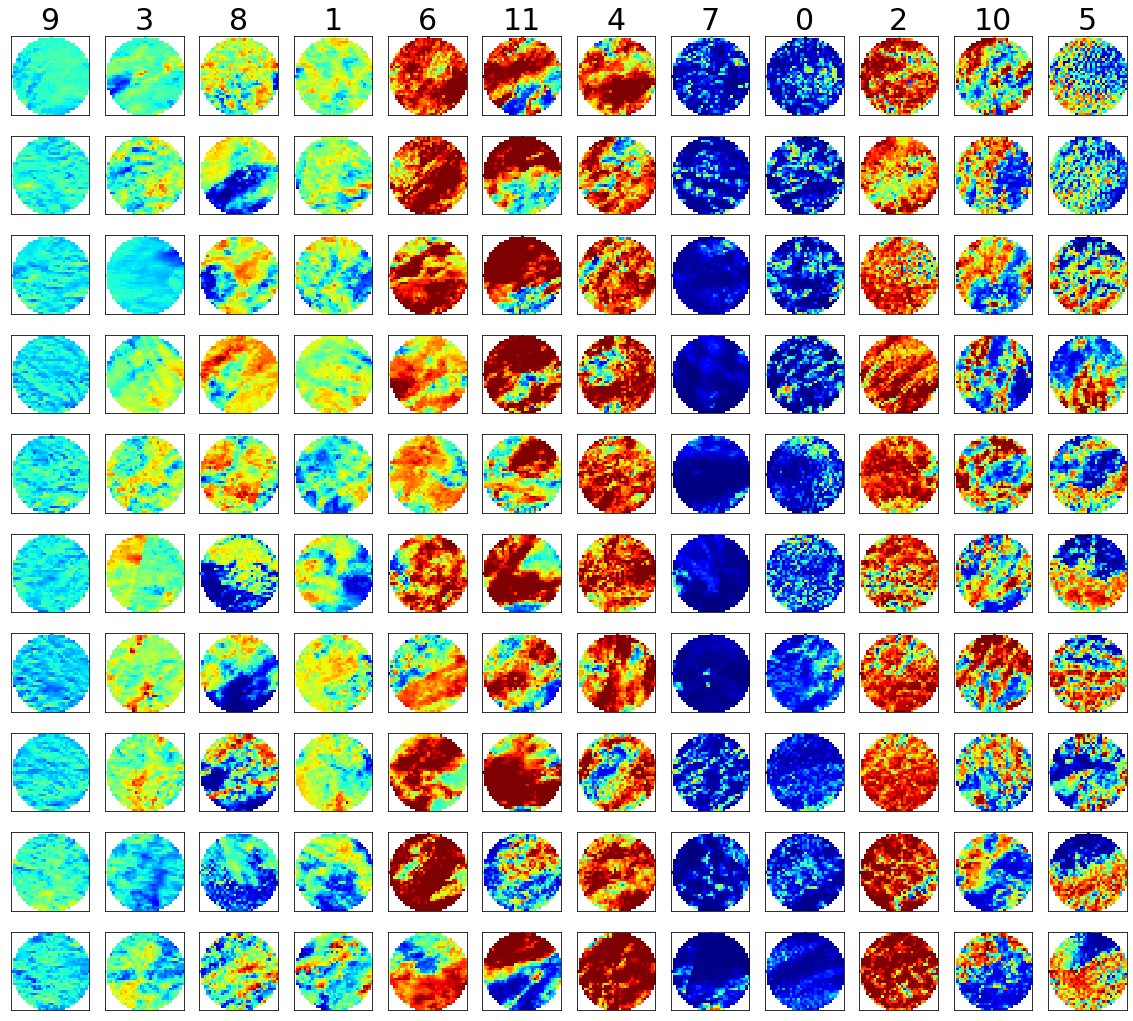

In [193]:
fsize=30
savedir = './figs'

fig,ax = plt.subplots(10,12,figsize=(20,18))
for i, num_icluster in enumerate([23,37, 26,48,25,10,14,42,137,65,30,34 ]):
    icluster = icluster_list.index(num_icluster)
    tmps = dict_topNs[f'cluster-{icluster}']
    cdx = np.where(clabels == icluster)
    isize = 10
    for j in range(isize):
            index = cdx[0][tmps[j][0]]
            ax[j,i].imshow(patches[index, :,:,0]*nan_mask, cmap='jet',vmin=0,vmax=1 )
            ax[j,i].xaxis.set_visible(False)
            ax[j,i].yaxis.set_visible(False)
            if j == 0:
                ax[0,i].set_title(f'{icluster}', fontsize=fsize)
#plt.show()
    #ax.set_ylabel('Bhattacharyya',fontsize=20)
pdf = PdfPages(os.path.join(savedir, "cloudimage_12_Dec12015.pdf") )
plt.savefig(pdf, format='pdf', bbox_inches='tight')
pdf.close()
pdf = None

--------------------------
### Visualize t- SNE

In [50]:
def compute_tsne(data, ndim=2, nperplex=15):
    tsne = TSNE(n_components=ndim, perplexity=nperplex,random_state=0)
    features = tsne.fit_transform(data)
    return features 

In [51]:
pred.shape

(491, 16, 16, 64)

In [52]:
n,_h,_w,c = pred.shape
latent = pred.reshape((n,_h*_w*c ))
feat_2d = compute_tsne(latent, ndim=2, nperplex=35)

In [53]:
colors = ['blueviolet','cornflowerblue','blue','teal',
         'aqua','palegreen', 'yellowgreen', 'pink',
         'yellow','orange','red','maroon', 'Grey']

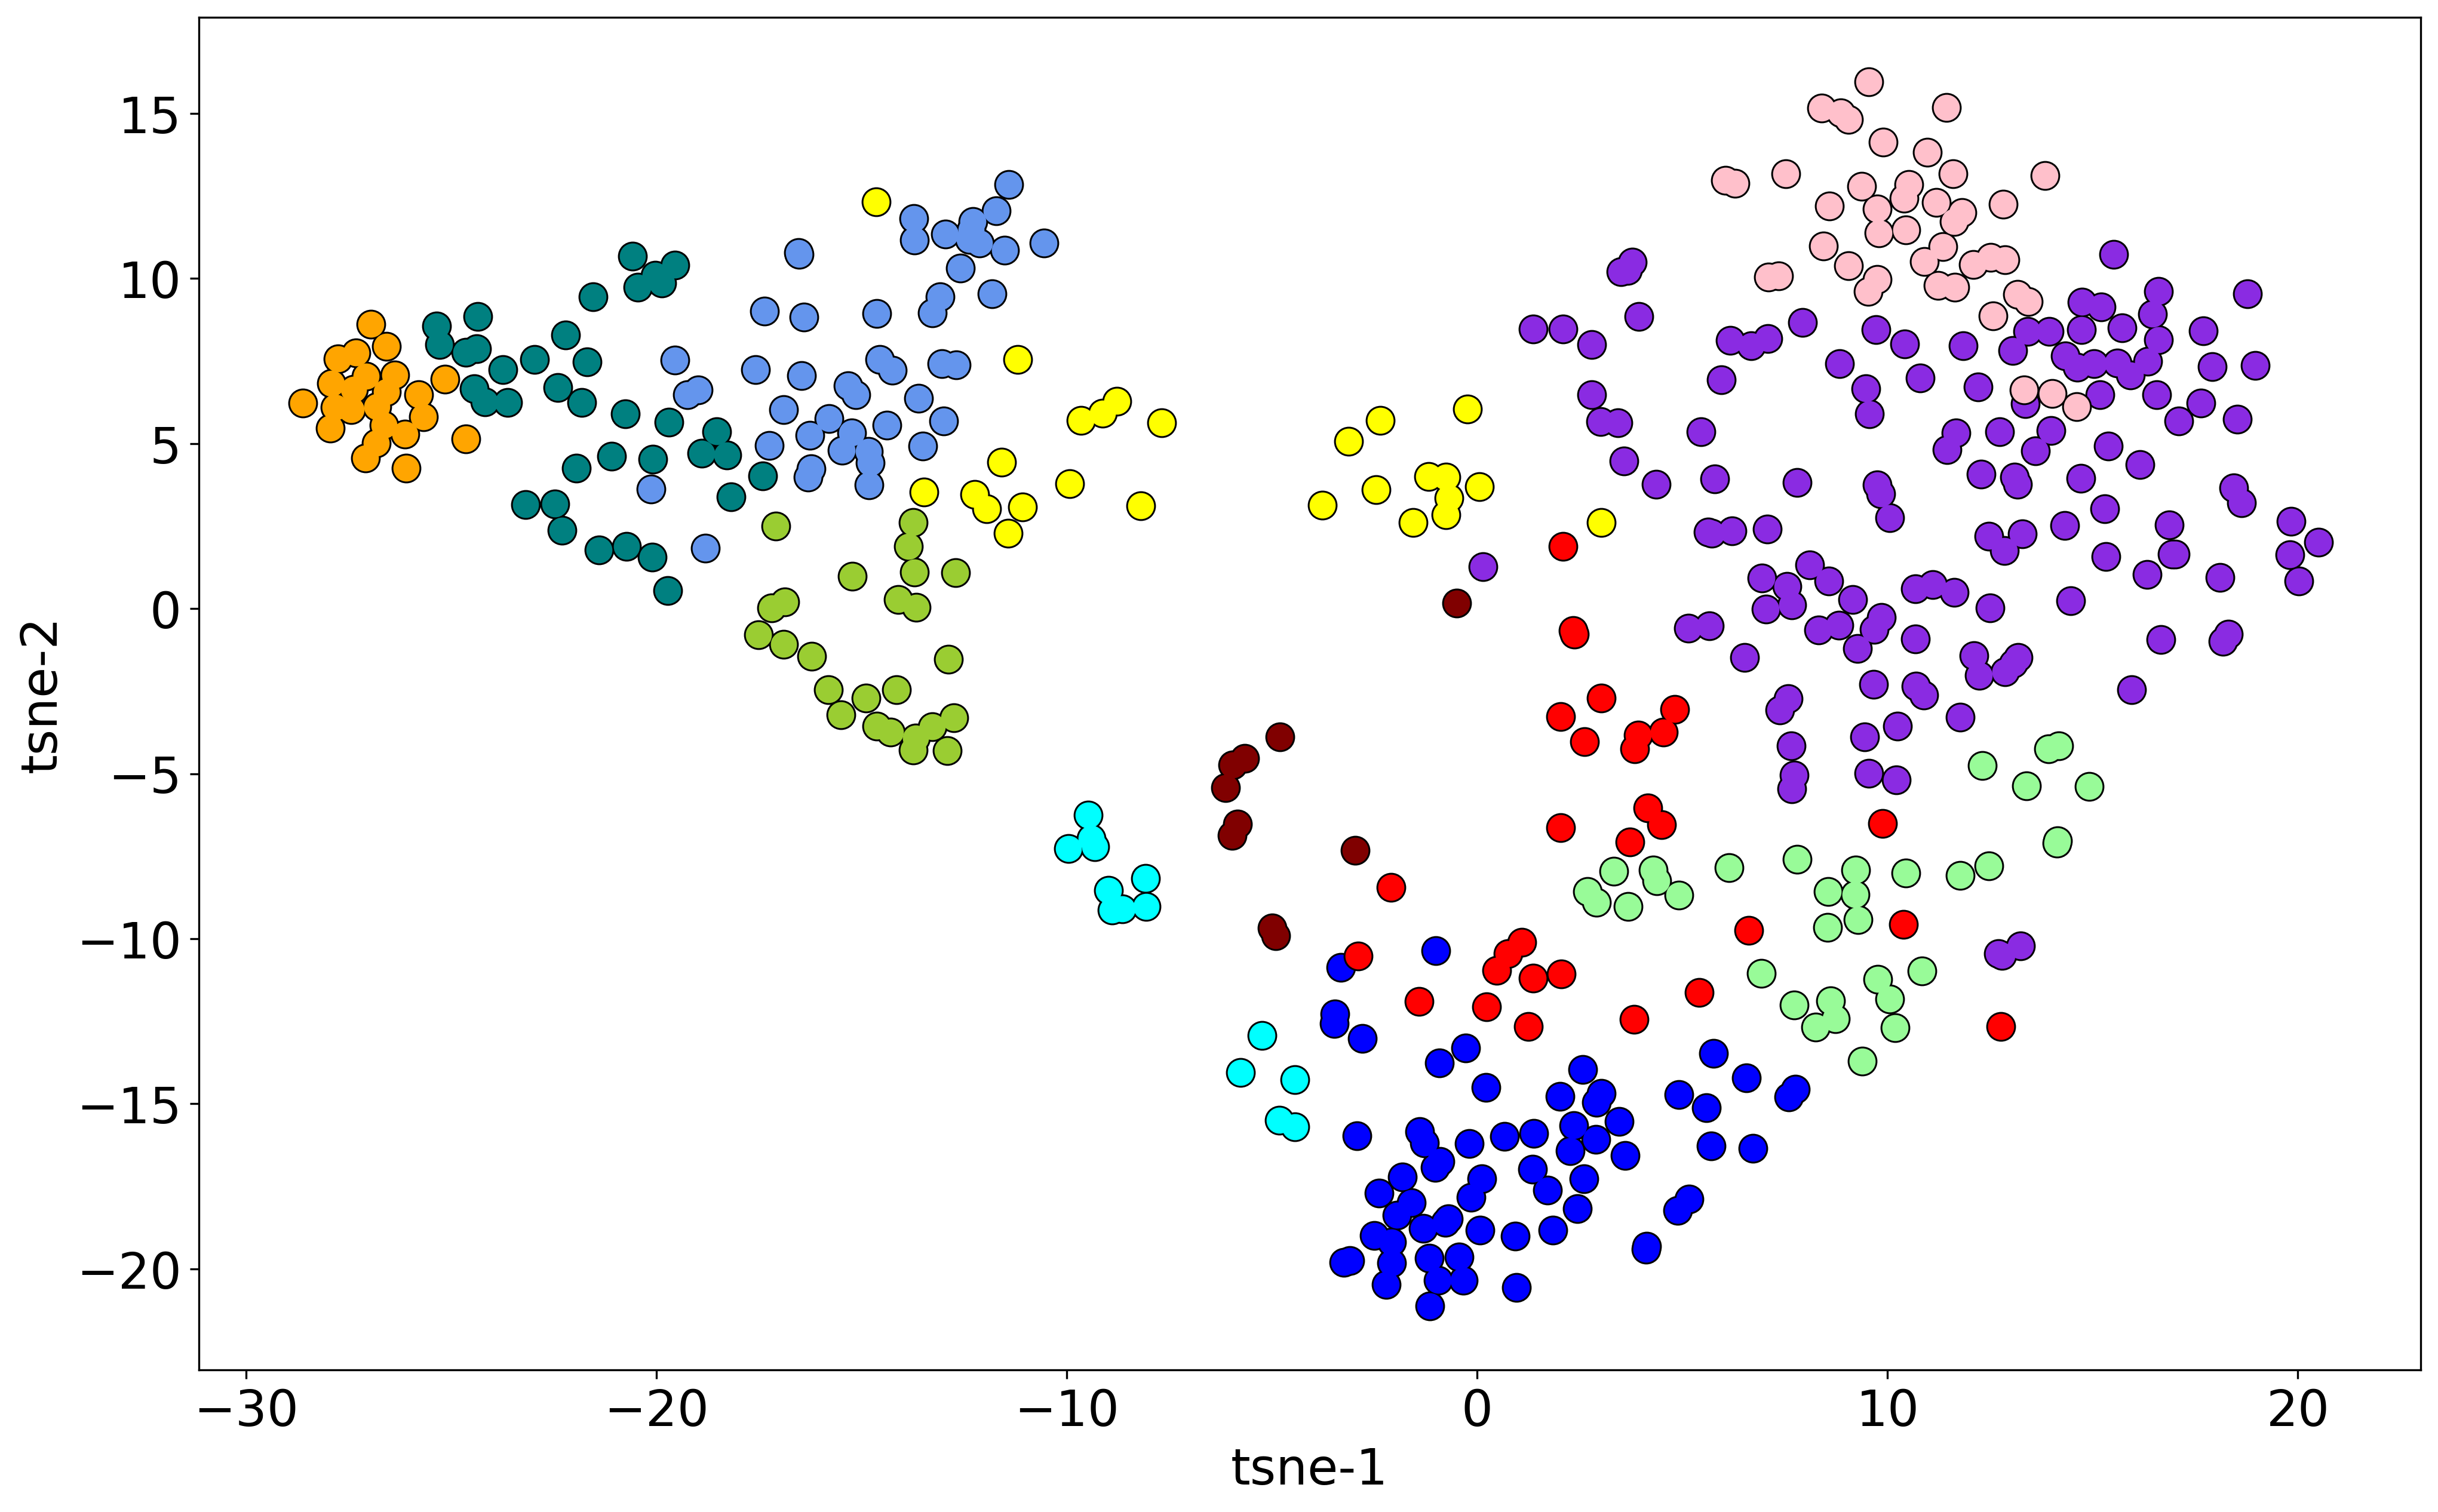

In [77]:
fig = plt.figure(figsize=(16,10), dpi=300)
for i in range(12):
    idx = np.where(clabels == i)
    plt.scatter(feat_2d[idx,0], feat_2d[idx,1], s=120, color='black')
    plt.scatter(feat_2d[idx,0], feat_2d[idx,1], s=90, color=colors[i])
plt.xlabel('tsne-1', fontsize=20)
plt.ylabel('tsne-2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.show()
plt.savefig("./nori_separable_ri.png")

---------------
### Visualize on map

In [59]:
#Access visual data
vis_file = "/home/tkurihana/clouds/analysis_mod021KM/data/MOD02/MOD021KM.A2015335.mosaic.061.2019272193957.psmcgscs_000501379937.EV_250_Aggr1km_RefSB_1.hdf"
vhdf = SD(vis_file, SDC.READ)
vhdf_sds = vhdf.select("EV_250_Aggr1km_RefSB")
vhdf_array, vis_band = proc_sds(vhdf_sds)

Process bands 1


In [60]:
vhdf_array.shape

(3562, 3540)

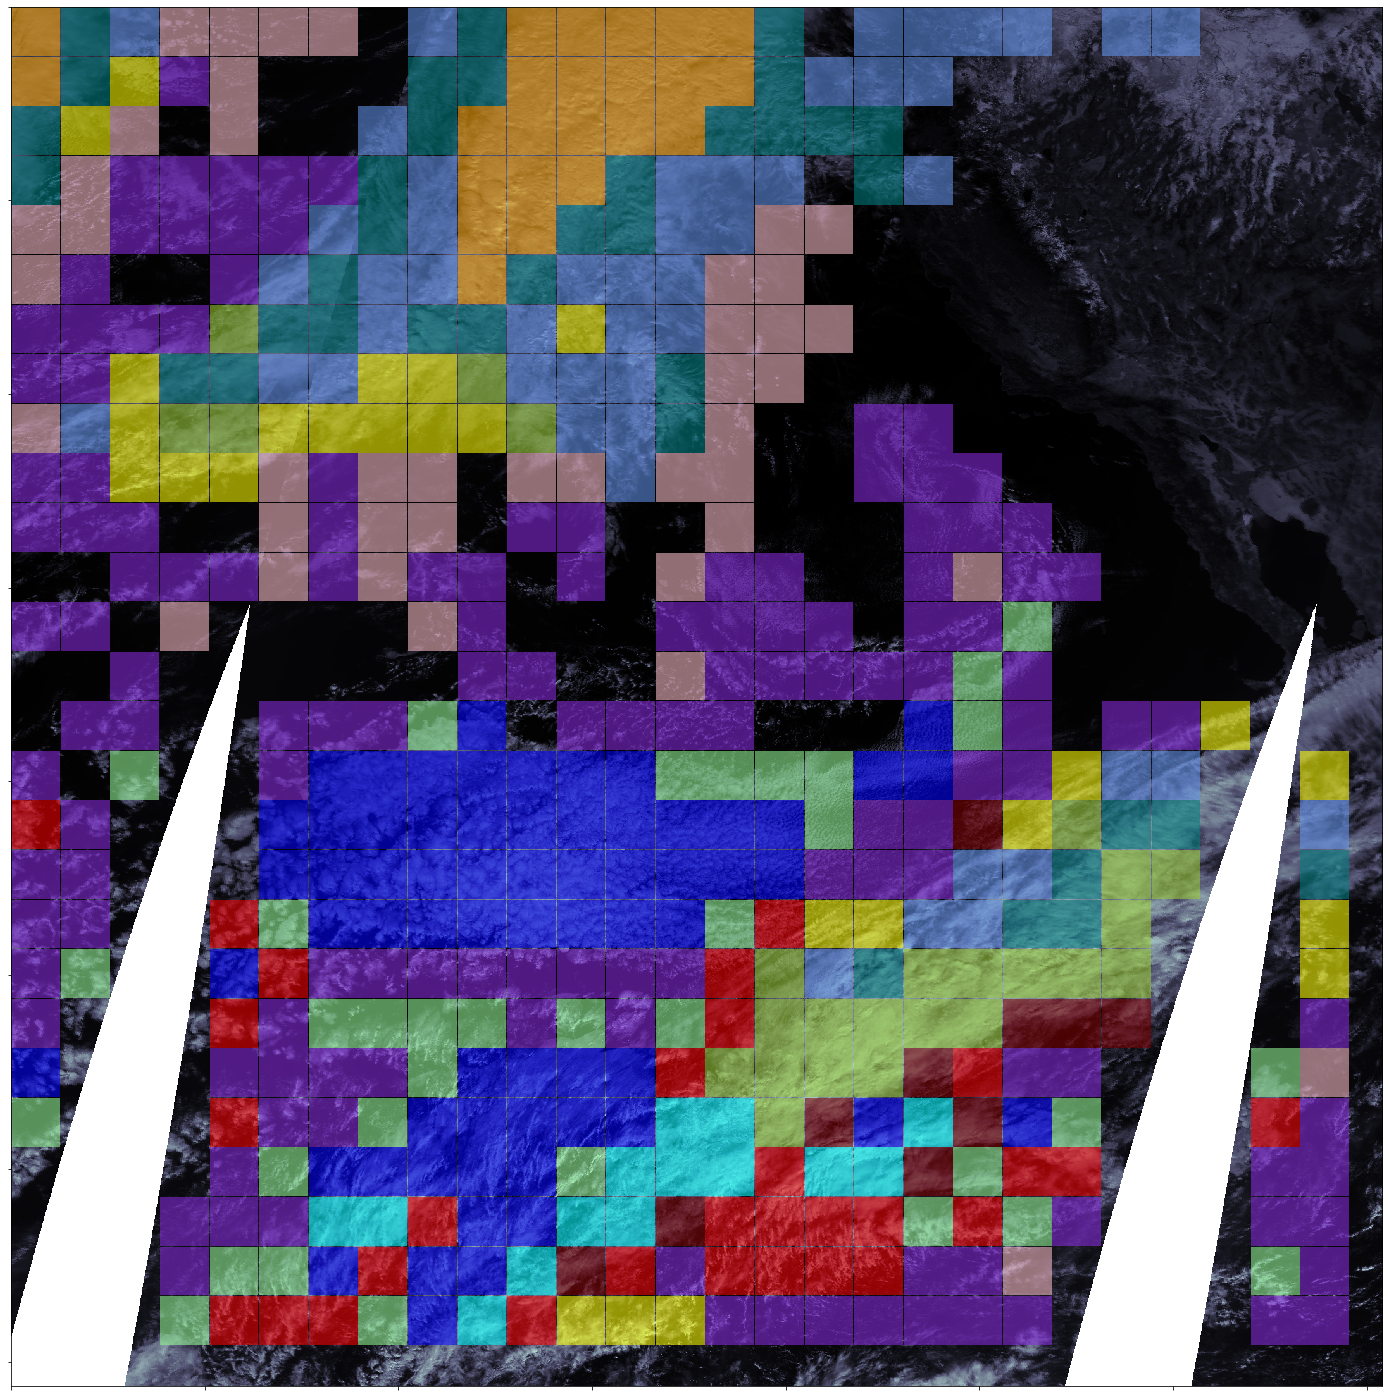

In [130]:
#Plot location of cluster patches on top of visual band image
fig = plt.figure(figsize=(20,20))

line_width = 1
SHAPE = 1,1 #128,128
_SHAPE = 128,128
colors = ['blueviolet','cornflowerblue','blue','teal',
         'aqua','palegreen', 'yellowgreen', 'pink',
         'yellow','orange','red','maroon', 'Grey']

ax = plt.subplot(1,1,1)
plt.imshow(vhdf_array, cmap='bone')
for idx, (coord,icluster) in enumerate(zip(coord_list, clabels)):  
    i,j = coord
    ax.add_patch(mpl_patches.Rectangle(
        (j * SHAPE[0] + line_width , i * SHAPE[1] + line_width ),
        width=_SHAPE[0] - line_width * 2,
        height=_SHAPE[1] - line_width * 2,
        linewidth=0,
        edgecolor=colors[icluster],
        facecolor='none',
        alpha=0.25
    ))
    #======================================
    ax.add_patch(mpl_patches.Rectangle(
        (j * SHAPE[0] + line_width , i * SHAPE[1] + line_width ),
        width=_SHAPE[0] - line_width * 2,
        height=_SHAPE[1] - line_width * 2,
        linewidth=0,
        edgecolor=colors[icluster],
        facecolor=colors[icluster],
        alpha=0.57
    ))
                    
fig.tight_layout()
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()
#plt.savefig("Visual_clusters_
plt.close()

------------------
### MOD06 Analysis

#### Load and Decode MOD06

In [22]:
m6dir='/home/tkurihana/scratch-midway2/clouds/analysis_mod021KM/data/MOD06'

In [23]:
m6bname='MOD06_L2.A2015335.mosaic.061.2019271230459.psmcgscs_000501379737'

In [24]:
m6bname2 = 'MOD06_L2.A2015335.mosaic.061.2019272191512.psmcgscs_000501379928'

In [25]:
hdf_filelist=[
    m6dir+'/'+str(m6bname)+'.Cloud_Water_Path.hdf',
    m6dir+'/'+str(m6bname2)+'.Cloud_Phase_Infrared_1km.hdf',
    m6dir+'/'+str(m6bname)+'.cloud_top_pressure_1km.hdf',
    m6dir+'/'+str(m6bname)+'.Cloud_Optical_Thickness.hdf',
    m6dir+'/'+str(m6bname)+'.Cloud_Effective_Radius.hdf'
]

hdf_water_path = (SD(hdf_filelist[0], SDC.READ)).select("Cloud_Water_Path")
hdf_phase_infrared = (SD(hdf_filelist[1], SDC.READ)).select("Cloud_Phase_Infrared_1km")
hdf_top_pressure = (SD(hdf_filelist[2], SDC.READ)).select("cloud_top_pressure_1km")
hdf_optical_thickness = (SD(hdf_filelist[3], SDC.READ)).select("Cloud_Optical_Thickness")
hdf_effective_radius = (SD(hdf_filelist[4], SDC.READ)).select("Cloud_Effective_Radius")

Decode and get stats data

In [26]:
## decoding process
params = [hdf_water_path,hdf_phase_infrared,hdf_top_pressure,hdf_optical_thickness, hdf_effective_radius]
decoded = []
for jdx, hdf_sds in enumerate(params):
    array = hdf_sds.get()
    array = array.astype(np.float64)
    # Get FillValue index
    nan_idx = np.where( array == hdf_sds.attributes()['_FillValue'])
    if len(nan_idx) > 0:
        array[nan_idx] = np.nan
    else:
        pass
    # radiance offset
    offset = hdf_sds.attributes()['add_offset']
    array = array - offset
    # radiance scale
    scales = hdf_sds.attributes()['scale_factor']
    array = array*scales
    ### Error Value process
    #if str(hdf_sds) == 'hdf_optical_thickness':
    if jdx == 3:
        err_idx = np.where(array > 100.0) # optical thickness range[0,100] no unit
        array[err_idx] = np.nan
    decoded.append(array)
nx, ny = decoded[0].shape
d_list = [
    decoded[3].reshape(nx,ny,1),
    decoded[0].reshape(nx,ny,1),
    decoded[1].reshape(nx,ny,1),
    decoded[2].reshape(nx,ny,1),
    decoded[4].reshape(nx,ny,1)
]

In [27]:
mod06_img = np.concatenate(d_list, axis=2)
mod06_patches = _gen_patches(mod06_img, normalization=False, flag_nan=True)

In [28]:
mod06_patches.shape

(27, 27, 128, 128, 5)

In [29]:
#Find stats (mean, mode) of mod06 patches 
statistics = np.zeros((mod06_patches.shape[0],mod06_patches.shape[1],mod06_patches.shape[4]))

nx = mod06_patches.shape[0]
ny = mod06_patches.shape[1]

#Make empty arrays
optical_thickness = np.zeros((nx*128, ny*128)).astype(float)
water_path = np.zeros((nx*128, ny*128)).astype(float)
phase_infrared = np.zeros((nx*128, ny*128)).astype(float)
top_pressure = np.zeros((nx*128, ny*128)).astype(float)
effective_radius = np.zeros((nx*128, ny*128)).astype(float)

wp, pi, tp, ot, er = [], [], [], [], []

#Fill in arrays 
for param in range(mod06_patches.shape[4]):
    for i in range(0,nx):
        for j in range(0,ny):
            mean =  np.nanmean(mod06_patches[i,j,:,:,param])
            mode = sc.stats.mode(mod06_patches[i,j,:,:,param].ravel())[0][0]
            if param == 0:
                optical_thickness[i*128: (i+1)*128, j*128 : (j+1)*128] = mean
                ot.append(mean)
                statistics[i, j, param] = mean
            elif param == 1: 
                water_path[i*128: (i+1)*128, j*128 : (j+1)*128] = mean
                wp.append(mean)
                statistics[i, j, param] = mean
            elif param == 2: 
                if np.isnan(mean):
                    mode = mean
                phase_infrared[i*128: (i+1)*128, j*128 : (j+1)*128] = mode
                pi.append(mode)
                statistics[i, j, param] = mode
            elif param == 3: 
                top_pressure[i*128: (i+1)*128, j*128 : (j+1)*128] = mean
                tp.append(mean)
                statistics[i, j, param] = mean
            else: 
                effective_radius[i*128: (i+1)*128, j*128 : (j+1)*128] = mean
                er.append(mean)
                statistics[i, j, param] = mean

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


##### Reconstruct position of labels

In [32]:
def reconst_img(_patches, _patches_labels, _xy_list):
    ix, iy = _patches.shape[:2]
    img_array = np.zeros((ix,iy)).astype(np.float64)
    img_array[:,:] = np.nan
    for idx, (_x,_y) in enumerate(_xy_list):
        x = int(_x/128)
        y = int(_y/128)
        img_array[x,y] = _patches_labels[idx]
    return img_array

In [33]:
agl_cimg_array = reconst_img(mod06_patches, clabels, coord_list)

In [114]:
plt.imshow(agl_cimg_array)

##### Visualize patch stats

In [30]:
def compute_patch_stats(img_array, statistics, n_cluster=12):
    '''
    Find stats for patches within each cluster
    Args: 
        Img_array (2D array): input array of patches' cluster numbers 
        Statistics: statistics of patches calculated above 
        N_cluster: number of clusters 
    Returns: array containing statistics of each cluster's patches
    '''
    physics = []
    for icluster in range(n_cluster):
        #get index
        cluster_idx = np.where(img_array == icluster)
        physics += [statistics[cluster_idx]]
    return physics

In [34]:
agl_cimg_physics = compute_patch_stats(agl_cimg_array, statistics, n_cluster=nclusters)

#### Viusalize histgrams

In [35]:
colors = ['blueviolet','cornflowerblue','blue','teal',
         'aqua','palegreen', 'yellowgreen', 'pink',
         'yellow','orange','red','maroon', 'Grey']

In [38]:
#titles = [
#    r"$\bf{Optical \hspace{0.5} Thickness}$",
#    r"$\bf{Water \hspace{0.5} Path}$",
#    r"$\bf{Phase}$",
#    r"$\bf{Pressure}$",
#    r"$\bf{Effective \hspace{0.5} Radius}$"
#]
titles = [
    r"${Optical \hspace{0.5} Thickness}$",
    r"${Water \hspace{0.5} Path}$",
    r"${Phase}$",
    r"${Pressure}$",
    r"${Effective \hspace{0.5} Radius}$"
]
titles = ['COT','CWP','CPH','CTP','CER']

cmap_name = 'my_list'
cmap = colors

matplotlib.rc('font',size=15)
fig = plt.figure(figsize=(18,18))
it = 1
phys_colors = ['b','c','y','r','g']
#for iid, i in enumerate([0,4,10,11]):
for iid, i in enumerate([i for i in range(nclusters)]):
    for k in [0,2,3,4]:
        ax = plt.subplot(nclusters, 4, it)
        #===============================================
        # change here
        #===============================================
        tmp = agl_cimg_physics[i][:,k]
        #===============================================
        tmp = tmp[np.logical_not(np.isnan(tmp))]  
        
        if k == 0:
            plt.hist(tmp, bins=range(0, 60, 3), color=cmap[i],rwidth=.8)
            _i = iid+1
            ax.set_ylabel("%d" %  _i,  fontsize=22)
            #ax.yaxis.set_label_coords(-.1, 5)
            ax.set_xticks([l for l in range(0,60, 10)])
        elif k ==1 :
            plt.hist(tmp, bins=range(0, 1500, 75), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,1500,400)])
        elif k == 2:
            iidx = np.where(tmp >=5)
            ax.set_xlim(0,4)
            tmp[iidx] = 3 
            plt.hist(tmp, bins=range(0, 4, 1), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,4,1)])
            if i == 11:
                ax.set_xlim(0,4)
                ax.set_xticklabels('')
                ax.set_xticks([.5,1.5,2.5,3.5],      minor=True)
                ax.set_xticklabels(['Clear','Liquid','Ice',''], minor=True, fontsize=18)
        elif k ==3:
            plt.hist(tmp, bins=range(0, 1000, 40), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,1001,200)])
            ax.invert_xaxis()
        elif k == 4: 
            plt.hist(tmp, bins=range(0, 50, 2), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,50,10)])
        
        if i == 0:
            ax.set_title(" %s" % titles[k],fontsize=30) 
        if i != 11:
            plt.setp(ax.get_xticklabels(), visible=False)
        it += 1
        plt.gca().xaxis.grid(True)
#plt.tight_layout()
fig.align_labels()

#plt.subplots_adjust(bottom=.4, hspace=.4)
#plt.savefig("Compare/cimg_04_20clusters_with-rad")
#plt.show()
#plt.close()
os.makedirs('./figs', exist_ok=True)
pdf = PdfPages(os.path.join('./figs', "hist_ri_phys_12.pdf"))
plt.savefig(pdf, format='pdf', bbox_inches='tight')
pdf.close()
pdf = None

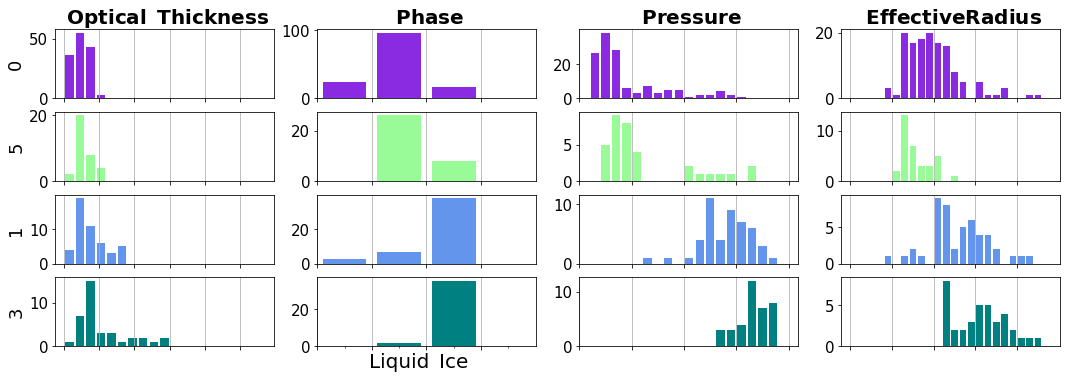

In [135]:
titles = [
    r"$\bf{Optical \hspace{0.5} Thickness}$",
    r"$\bf{Water \hspace{0.5} Path}$",
    r"$\bf{Phase}$",
    r"$\bf{Pressure}$",
    r"$\bf{Effective Radius}$"
]

cmap_name = 'my_list'
cmap = colors

matplotlib.rc('font',size=15)
fig = plt.figure(figsize=(18,18))
it = 1
phys_colors = ['b','c','y','r','g']
for iid, i in enumerate([0,5,1,3]):
#for iid, i in enumerate([i for i in range(nclusters)]):
    for k in [0,2,3,4]:
        ax = plt.subplot(nclusters, 4, it)
        #===============================================
        # change here
        #===============================================
        tmp = agl_cimg_physics[i][:,k]
        #===============================================
        tmp = tmp[np.logical_not(np.isnan(tmp))]  
        
        if k == 0:
            plt.hist(tmp, bins=range(0, 60, 3), color=cmap[i],rwidth=.8)
            ax.set_ylabel("%d" % i, fontsize=18)
            #ax.yaxis.set_label_coords(-.1, 5)
            ax.set_xticks([l for l in range(0,60, 10)])
        elif k ==1 :
            plt.hist(tmp, bins=range(0, 1500, 75), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,1500,400)])
        elif k == 2:
            iidx = np.where(tmp >=5)
            ax.set_xlim(0,4)
            tmp[iidx] = 3 
            plt.hist(tmp, bins=range(0, 4, 1), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,4,1)])
            if i == 3:
                ax.set_xlim(0,4)
                ax.set_xticklabels('')
                ax.set_xticks([.5,1.5,2.5,3.5],      minor=True)
                ax.set_xticklabels(['','Liquid','Ice',''], minor=True, fontsize=20)
                #ax.set_xticklabels(['Clear','Liquid','Ice',''], minor=True, fontsize=18)
        elif k ==3:
            plt.hist(tmp, bins=range(200, 1000, 40), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(200,1001,200)])
            ax.invert_xaxis()
        elif k == 4: 
            plt.hist(tmp, bins=range(0, 50, 2), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,50,10)])
        
        if i == 0:
            ax.set_title(" %s" % titles[k],fontsize=20) 
        if i != 11:
            plt.setp(ax.get_xticklabels(), visible=False)
        it += 1
        plt.gca().xaxis.grid(True)
#plt.tight_layout()
fig.align_labels()

#plt.subplots_adjust(bottom=.4, hspace=.4)
#plt.savefig("Compare/cimg_04_20clusters_with-rad")
plt.show()
plt.close()

In [137]:
matplotlib.rc('font',size=12)
fig = plt.figure(figsize=(18,18))
it = 1
phys_colors = ['b','c','y','r','g']
for iid, i in enumerate([2,1,3]):
#for iid, i in enumerate([i for i in range(nclusters)]):
    for k in [0,2,3,4]:
        ax = plt.subplot(nclusters, 4, it)
        #===============================================
        # change here
        #===============================================
        tmp = agl_cimg_physics[i][:,k]
        #===============================================
        tmp = tmp[np.logical_not(np.isnan(tmp))]  
        
        if k == 0:
            plt.hist(tmp, bins=range(0, 60, 3), color=cmap[i],rwidth=.8)
            ax.set_ylabel("%d" % i, fontsize=18)
            #ax.yaxis.set_label_coords(-.1, 5)
            ax.set_xticks([l for l in range(0,60, 10)])
        elif k ==1 :
            plt.hist(tmp, bins=range(0, 1500, 75), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,1500,400)])
        elif k == 2:
            iidx = np.where(tmp >=5)
            ax.set_xlim(0,4)
            tmp[iidx] = 3 
            plt.hist(tmp, bins=range(0, 4, 1), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,4,1)])
            if i == 3:
                ax.set_xlim(0,4)
                ax.set_xticklabels('')
                ax.set_xticks([.5,1.5,2.5,3.5],      minor=True)
                ax.set_xticklabels(['','Liquid','Ice',''], minor=True, fontsize=20)
                #ax.set_xticklabels(['Clear','Liquid','Ice',''], minor=True, fontsize=18)
        elif k ==3:
            plt.hist(tmp, bins=range(200, 1000, 40), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(200,1001,200)])
            ax.invert_xaxis()
        elif k == 4: 
            plt.hist(tmp, bins=range(0, 50, 2), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,50,10)])
        
        if i == 0:
            ax.set_title(" %s" % titles[k],fontsize=20) 
        if i != 11:
            plt.setp(ax.get_xticklabels(), visible=False)
        it += 1
        plt.gca().xaxis.grid(True)
#plt.tight_layout()
fig.align_labels()

#plt.subplots_adjust(bottom=.4, hspace=.4)
#plt.savefig("Compare/cimg_04_20clusters_with-rad")
plt.show()
plt.close()

In [ ]:
matplotlib.rc('font',size=12)
fig = plt.figure(figsize=(18,18))
it = 1
phys_colors = ['b','c','y','r','g']
for iid, i in enumerate([2,1,3]):
#for iid, i in enumerate([i for i in range(nclusters)]):
    for k in [0,2,3,4]:
        ax = plt.subplot(nclusters, 4, it)
        #===============================================
        # change here
        #===============================================
        tmp = agl_cimg_physics[i][:,k]
        #===============================================
        tmp = tmp[np.logical_not(np.isnan(tmp))]  
        
        if k == 0:
            plt.hist(tmp, bins=range(0, 60, 3), color=cmap[i],rwidth=.8)
            ax.set_ylabel("%d" % i, fontsize=18)
            #ax.yaxis.set_label_coords(-.1, 5)
            ax.set_xticks([l for l in range(0,60, 10)])
        elif k ==1 :
            plt.hist(tmp, bins=range(0, 1500, 75), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,1500,400)])
        elif k == 2:
            iidx = np.where(tmp >=5)
            ax.set_xlim(0,4)
            tmp[iidx] = 3 
            plt.hist(tmp, bins=range(0, 4, 1), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,4,1)])
            if i == 3:
                ax.set_xlim(0,4)
                ax.set_xticklabels('')
                ax.set_xticks([.5,1.5,2.5,3.5],      minor=True)
                ax.set_xticklabels(['','Liquid','Ice',''], minor=True, fontsize=20)
                #ax.set_xticklabels(['Clear','Liquid','Ice',''], minor=True, fontsize=18)
        elif k ==3:
            plt.hist(tmp, bins=range(200, 1000, 40), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(200,1001,200)])
            ax.invert_xaxis()
        elif k == 4: 
            plt.hist(tmp, bins=range(0, 50, 2), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,50,10)])
        
        if i == 0:
            ax.set_title(" %s" % titles[k],fontsize=20) 
        if i != 11:
            plt.setp(ax.get_xticklabels(), visible=False)
        it += 1
        plt.gca().xaxis.grid(True)
#plt.tight_layout()
fig.align_labels()

#plt.subplots_adjust(bottom=.4, hspace=.4)
#plt.savefig("Compare/cimg_04_20clusters_with-rad")
plt.show()
plt.close()

---------------------
### For Paper: Combine tsne + phys dist figures

In [48]:
gc.collect()

0

In [58]:
"""Ref: https://realpython.com/python-matplotlib-guide/
"""

cmap_name = 'my_list'
cmap = colors
#
gridsize = (14,8) #(7,4)
matplotlib.rc('font',size=16)
fig = plt.figure(figsize=(14,14))
ax= [
    plt.subplot2grid(gridsize, (0, 1), colspan=6, rowspan=7,),
    ]+[plt.subplot2grid(gridsize, (8+2*i, 2*j),colspan=2, rowspan=2) for i in range(3) for j in range(4)]

#===================== Fig TSNE
for i in range(12):
    idx = np.where(clabels == i)
    ax[0].scatter(feat_2d[idx,0], feat_2d[idx,1], s=120, color='black')
    ax[0].scatter(feat_2d[idx,0], feat_2d[idx,1], s=90, color=colors[i])
ax[0].set_xlabel('tsne-1', fontsize=20)
ax[0].set_ylabel('tsne-2', fontsize=20)
#ax[0].set_xticklabels(fontsize=20)
#ax[0].set_yticklabels(fontsize=20)


#===================== Fig HiST 
titles = ['COT','CWP','CPH','CTP','CER']
it = 1
phys_colors = ['b','c','y','r','g']
for iid, i in enumerate([1,2,3]):
#for iid, i in enumerate([i for i in range(nclusters)]):
    for k in [0,2,3,4]:
        #ax = plt.subplot(nclusters, 4, it)
        iax = it
        #===============================================
        # change here
        #===============================================
        tmp = agl_cimg_physics[i][:,k]
        #===============================================
        tmp = tmp[np.logical_not(np.isnan(tmp))]  
        
        if k == 0:
            ic = i+1
            ax[iax].hist(tmp, bins=range(0, 60, 3), color=cmap[i],rwidth=.8)
            ax[iax].set_ylabel("%d" % ic, fontsize=23)
            #ax.yaxis.set_label_coords(-.1, 5)
            ax[iax].set_xticks([l for l in range(0,60, 10)])
        elif k ==1 :
            ax[iax].hist(tmp, bins=range(0, 1500, 75), color=cmap[i],rwidth=.8)
            ax[iax].set_xticks([l for l in range(0,1500,400)])
        elif k == 2:
            iidx = np.where(tmp >=5)
            ax[iax].set_xlim(0,4)
            tmp[iidx] = 3 
            ax[iax].hist(tmp, bins=range(0, 4, 1), color=cmap[i],rwidth=.8)
            ax[iax].set_xticks([l for l in range(0,4,1)])
            if i == 3:
                ax[iax].set_xlim(0,4)
                ax[iax].set_xticklabels('')
                ax[iax].set_xticks([.5,1.5,2.5,3.5],      minor=True)
                ax[iax].set_xticklabels(['Clear','Liquid','Ice',''], minor=True, fontsize=18)
                #ax.set_xticklabels(['Clear','Liquid','Ice',''], minor=True, fontsize=18)
        elif k ==3:
            ax[iax].hist(tmp, bins=range(200, 1000, 40), color=cmap[i],rwidth=.8)
            ax[iax].set_xticks([l for l in range(200,1001,200)])
            ax[iax].invert_xaxis()
        elif k == 4: 
            ax[iax].hist(tmp, bins=range(0, 50, 2), color=cmap[i],rwidth=.8)
            ax[iax].set_xticks([l for l in range(0,50,10)])
        
        if i == 1:
            ax[iax].set_title(" %s" % titles[k],fontsize=35) 
        #if i != 11:
        if i !=3:
            #ax[iax].setp(ax[iax].get_xticklabels(), visible=False)
            ax[iax].set_xticklabels([])
        it += 1
        ax[iax].grid(True, axis='x')
fig.tight_layout(pad=-.5, w_pad=-.5, h_pad=-.5)
#fig.align_labels()


# add annotation
"""
https://matplotlib.org/3.1.1/gallery/units/ellipse_with_units.html#sphx-glr-gallery-units-ellipse-with-units-py
https://stackoverflow.com/questions/9230389/why-is-matplotlib-plotting-my-circles-as-ovals
"""
# 1
ax[0].add_artist( Ellipse( (-15, 8),width=16,height=8.5, color=colors[1],linewidth=6, angle=60,  fill=False))
ax[0].text(-8, 8.8,'#2', color=colors[1], fontsize=45, fontweight='semibold')

# 2
ax[0].add_artist( Ellipse( (2, -16),width=14,height=12, color=colors[2],linewidth=6, angle=45,  fill=False))
ax[0].text(-12, -19,'#3', color=colors[2], fontsize=45, fontweight='semibold')

# 3
ax[0].add_artist( Ellipse( (-21, 6),width=16,height=9.5, color=colors[3],linewidth=6, angle=300,  fill=False))
ax[0].text(-25, -5,'#4', color=colors[3], fontsize=45, fontweight='semibold')

#plt.subplots_adjust(bottom=.4, hspace=.4)
#plt.savefig("Compare/cimg_04_20clusters_with-rad")
#plt.show()
os.makedirs('./figs', exist_ok=True)
pdf = PdfPages(os.path.join('./figs', "test3_sep_ri_phy_12.pdf"))
plt.savefig(pdf, format='pdf', bbox_inches='tight')
pdf.close()
pdf = None
#plt.close()